In [2]:
import numpy as np
import pandas as pd
import os
import sqlite3
from nltk.corpus import stopwords
sw2 = stopwords.words("english")
from string import punctuation
punctuation = set(punctuation)
punctuation.add("’")
import datetime
import time
from random import sample
import random

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,LdaMulticore, Phrases 
from gensim.models.phrases import Phraser 
from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.gensim_models

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from pprint import pprint
from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

Lemmatizer = nlp.get_pipe("lemmatizer")

In [3]:
import datetime
import tweepy
from tweepy import OAuthHandler
import json
import pandas as pd
import csv
import re
import string
import os
import time
import random
import numpy as np
from nltk.corpus import stopwords
sw = stopwords.words('english')
from string import punctuation
from collections import Counter, defaultdict
from pprint import pprint
from operator import itemgetter
import matplotlib.pyplot as plt


# I've put my API keys in a .py file called API_keys.py
from my_api_keys import api_key, api_key_secret, access_token, access_token_secret

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Authenticate the Tweepy API
auth = tweepy.OAuthHandler(api_key,api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Modifications to punctuation and sw lists

punctuation = set(punctuation)
punctuation.add("’")

sw2 = set(sw)
addl = ("|","-","/","•","&", "&amp;")
sw2.update(addl)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


####  Read daily tweets CSVs into pandas dataframe

In [6]:
db = pd.DataFrame(columns = ['user_id','screen_name','description','location','friends_count',
           'followers_count','totaltweets','date_created', 'tweet_id', 'retweetcount','full_text'])

file_location = "/Users/natebender/Desktop/Repo/text-mining/datashare_AA_COP_tweets/data/"
files = sorted(os.listdir(file_location))
for idx, file in enumerate(files):
    
    data = "".join([file_location,file])
    datafile = pd.read_csv(data)

    db = db.append(datafile,ignore_index=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Check desc stats on overall descriptions before splitting into groups
def get_patterns(all_tweets) :

    all_desc = all_tweets.dropna()
    all_str = " ".join(all_desc)    
    clean = [w for w in all_str.split() if w.lower() not in sw2]
    
    # Calculate your statistics here
    total_tokens = len(clean)
    unique_tokens = len(set(clean))
    clean_tok_len = [len(w) for w in clean]
    avg_token_len = np.mean(clean_tok_len)
    lex_diversity = len(set(clean))/len(clean)
    top_n = Counter(clean).most_common(20)
    
    
    # Now we'll fill out the dictionary. 
    results = {'tokens':total_tokens,
               'unique_tokens':unique_tokens,
               'avg_token_length':round(avg_token_len,2),
               'lexical_diversity':round(lex_diversity,2),
               'Top_n':top_n}

    return(results)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Introduction
This Acquire & Analyze workbook covers a topic modeling analysis and sentiment analysis of tweets related to the COP26 climate negotiations that took place from October 31st to November 12, 2021 in Glasgow, Scotland. 

Throughout the two weeks, the conference covered a number of climate themes on different days. My goal with this analysis is to uncover whether it is possible to find distinct groupings of tweets related to these themes, and, if that is possible, to track the sentiment of the distinct groupings throughout the conference. 

With any luck, these two analyses together will show how Twitter can be used to track distinct areas of discussion throughout an event, and see how the sentiment on Twitter for these areas evolves in reaction to the event. 

#### COP26 schedule

Sunday 31 October - Procedural opening of negotiations

Monday and Tuesday 1-2 November - World leaders summit: A two-day event welcoming heads of state and inviting them to put forward their ambitions and proposals towards securing global net zero carbon emissions, keeping the 1.5C temperature increase target within reach, protecting ecosystems and mobilising finance

Wednesday 3 November - Finance: Mobilising public and private finance flows at scale for mitigation and adaptation

Thursday 4 November - Energy: Accelerating the global transition to clean energy

Friday 5 November - Youth and public empowerment: Elevating the voice of young people and demonstrating the critical role of public empowerment and education in climate action

Saturday 6 November - Nature: Ensuring the importance of nature and sustainable land use are part of global action on climate change and a clean, green recovery

Sunday 7 November - Rest day

Monday 8 November - Adaptation, loss and damage: Delivering the practical solutions solutions needed to adapt to climate impact and address loss and damage

Tuesday 9 November - Gender: Progressing gender equality and the full and meaningful participation of women and girls in climate action
Science and innovation: Demonstrating that research and technology can deliver climate solutions to meet, and accelerate, increased ambition

Wednesday 10 November - Transport: Driving the global transition to zero emission transport

Thursday 11 November - Cities, Regions and Built Environment: Advancing action in the places we live, from communities, through to cities and regions  
  
Friday 12 November - Closure of negotiations

#### Descriptive stats on tweets
Let's first look at the descriptive stats for the tweets scraped

15k tweets were scraped from Twitter for each day of the conference if they included either hashtag "#cop26" or "#cop26glasgow" (or variations of those)

In [8]:
all_tweets = db.full_text.dropna()
print(f'Database: {"{:,}".format(len(db.tweet_id))} tweets')
print(f'Descriptive stats are:')
get_patterns(all_tweets)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Database: 285,084 tweets
Descriptive stats are:


{'tokens': 5523996,
 'unique_tokens': 170153,
 'avg_token_length': 7.82,
 'lexical_diversity': 0.03,
 'Top_n': [('#COP26', 227147),
  ('climate', 57446),
  ('#COP26Glasgow', 24133),
  ('world', 20434),
  ('#cop26', 18871),
  ('need', 18435),
  ('fossil', 17574),
  ('change', 15756),
  ('#Unknown', 15720),
  ('leaders', 14933),
  ('people', 13392),
  ('#ClimateAction', 13153),
  ('Climate', 12960),
  ('Glasgow', 12833),
  ('global', 11994),
  ('action', 11760),
  ('#ClimateCrisis', 11448),
  ('#COP26.', 10836),
  ('us', 10811),
  ('like', 10464)]}

In [10]:
import random
import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from matplotlib.pyplot import text


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Subset dataframe to multiple 3-day windows

w1_text = db.full_text[(db['date_created']>= "2021-10-28") & (db['date_created']< "2021-10-29")]
w2_text = db.full_text[(db['date_created']>= "2021-10-29") & (db['date_created']< "2021-10-30")]
w3_text = db.full_text[(db['date_created']>= "2021-10-30") & (db['date_created']< "2021-10-31")]
w4_text = db.full_text[(db['date_created']>= "2021-10-31") & (db['date_created']< "2021-11-01")]
w5_text = db.full_text[(db['date_created']>= "2021-11-01") & (db['date_created']< "2021-11-02")]
w6_text = db.full_text[(db['date_created']>= "2021-11-02") & (db['date_created']< "2021-11-03")]
w7_text = db.full_text[(db['date_created']>= "2021-11-03") & (db['date_created']< "2021-11-04")]
w8_text = db.full_text[(db['date_created']>= "2021-11-04") & (db['date_created']< "2021-11-05")]
w9_text = db.full_text[(db['date_created']>= "2021-11-05") & (db['date_created']< "2021-11-06")]
w10_text = db.full_text[(db['date_created']>= "2021-11-06") & (db['date_created']< "2021-11-07")]
w11_text = db.full_text[(db['date_created']>= "2021-11-07") & (db['date_created']< "2021-11-08")]
w12_text = db.full_text[(db['date_created']>= "2021-11-08") & (db['date_created']< "2021-11-09")]
w13_text = db.full_text[(db['date_created']>= "2021-11-09") & (db['date_created']< "2021-11-10")]
w14_text = db.full_text[(db['date_created']>= "2021-11-10") & (db['date_created']< "2021-11-11")]
w15_text = db.full_text[(db['date_created']>= "2021-11-11") & (db['date_created']< "2021-11-12")]
w16_text = db.full_text[(db['date_created']>= "2021-11-12") & (db['date_created']< "2021-11-13")]
w17_text = db.full_text[(db['date_created']>= "2021-11-13") & (db['date_created']< "2021-11-14")]
w18_text = db.full_text[(db['date_created']>= "2021-11-14") & (db['date_created']< "2021-11-15")]
w19_text = db.full_text[(db['date_created']>= "2021-11-15") & (db['date_created']< "2021-11-16")]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Sets up sentiment scores dictionary

sentiment_scores = {}

with open("tidytext_sentiments.txt",'r') as infile :
    next(infile)
    for line in infile.readlines() :
        line = line.strip().split("\t")
        if line[1] == "positive" :
            sentiment_scores[line[0]] = 1
        else :
            sentiment_scores[line[0]] = -1

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
dailytweets = [w1_text, w2_text, w3_text, w4_text, w5_text, w6_text, w7_text, w8_text, w9_text, w10_text,
              w11_text, w12_text, w13_text, w14_text, w15_text, w16_text, w17_text, w18_text, w19_text]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def sentiment_bywindow(timewindow) :
    tweets = list(timewindow)
    tweets_str = " ".join(tweets) 
    tweets_clean = [w for w in tweets_str.split() if w.lower() not in sw2]
    
    scores = []
    current_score = 0 

    for idx, word in enumerate(tweets_clean) :
        if word in sentiment_scores :
            current_score += sentiment_scores[word.lower()]
    
    scores.append(current_score)
        
#     filename = str(timewindow) + "_scores.csv"    
#     with open(filename,'w') as ofile :
#         ofile.write("word\tscore\n")
#         for idx, score in enumerate(scores) :
#             ofile.write("\t".join([str(idx+1),str(score)]) + "\n")
      
    return(scores)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
totalscores = []

for item in dailytweets:
    score = sentiment_bywindow(item)
    totalscores.append(score)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
anothergoddamnlist = []

for item in totalscores:
    anothergoddamnlist.append(item[0])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
import datetime
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


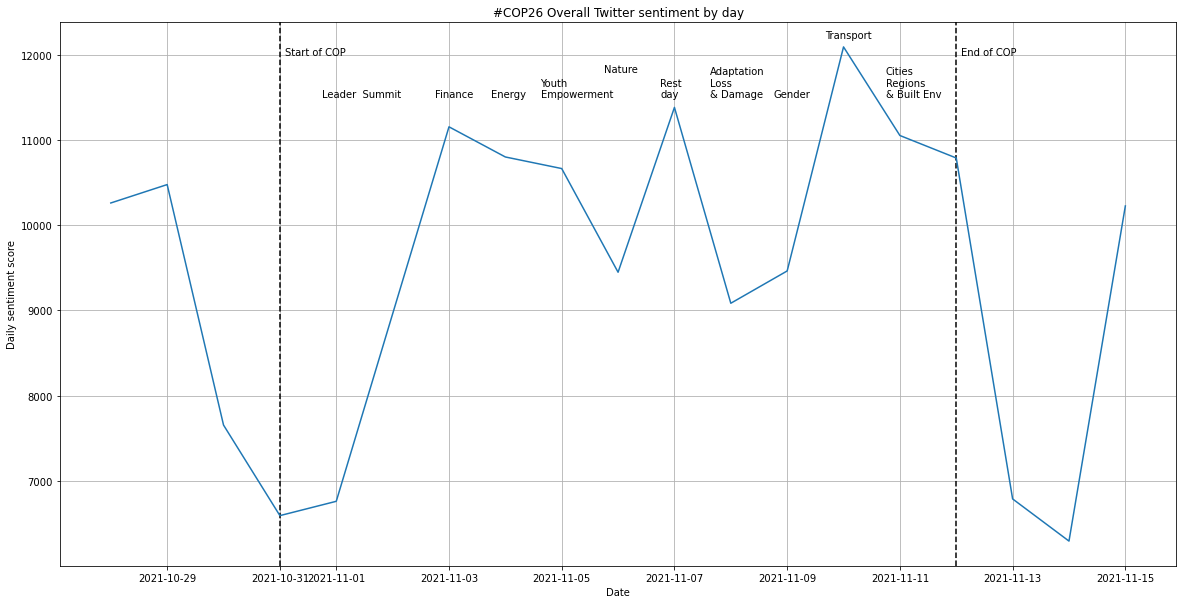

In [347]:
# Plantbasedtreaty    
#x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
x = [datetime.datetime(2021,10,28),datetime.datetime(2021,10,29),datetime.datetime(2021,10,30),
     datetime.datetime(2021,10,31),datetime.datetime(2021,11,1),datetime.datetime(2021,11,2),
     datetime.datetime(2021,11,3),datetime.datetime(2021,11,4),datetime.datetime(2021,11,5),
     datetime.datetime(2021,11,6),datetime.datetime(2021,11,7),datetime.datetime(2021,11,8),
     datetime.datetime(2021,11,9),datetime.datetime(2021,11,10),datetime.datetime(2021,11,11),
     datetime.datetime(2021,11,12),datetime.datetime(2021,11,13),datetime.datetime(2021,11,14),
     datetime.datetime(2021,11,15)]

y = anothergoddamnlist
plt.figure(figsize=(20,10))
plt.grid()

# xcoords = [datetime.datetime(2021,11,7), datetime.datetime(2021,11,10)]
# for xc in xcoords:
#     plt.axvline(x=xc, color='r', linestyle='dashed')

confcoords = [datetime.datetime(2021,10,31), datetime.datetime(2021,11,12)]
for xc in confcoords:
    plt.axvline(x=xc, color='black', linestyle='dashed')    
    
    
plt.annotate("Start of COP", (datetime.datetime(2021,10,31, hour=2), 12000))
plt.annotate("End of COP", (datetime.datetime(2021,11,12, hour=2), 12000))
plt.annotate("Leader  Summit", (datetime.datetime(2021,10,31, hour=18), 11500))
plt.annotate("Finance", (datetime.datetime(2021,11,2, hour=18), 11500))
plt.annotate("Energy", (datetime.datetime(2021,11,3, hour=18), 11500))
plt.annotate("Youth\nEmpowerment", (datetime.datetime(2021,11,4, hour=15), 11500))
plt.annotate("Nature", (datetime.datetime(2021,11,5, hour=18), 11800))
plt.annotate("Rest\nday", (datetime.datetime(2021,11,6, hour=18), 11500))
plt.annotate("Adaptation\nLoss\n& Damage", (datetime.datetime(2021,11,7, hour=15), 11500))
plt.annotate("Gender", (datetime.datetime(2021,11,8, hour=18), 11500))
plt.annotate("Transport", (datetime.datetime(2021,11,9, hour=16), 12200))
plt.annotate("Cities\nRegions\n& Built Env", (datetime.datetime(2021,11,10, hour=18), 11500))
    
#plt.xlim(
#    xmin=datetime.datetime(2021, 10, 28), # the one that doesn't change
#    xmax=datetime.datetime(2021, 11, 15) # the latest datetime in your dataset
plt.plot(x, y)

#sample_dates = np.array([datetime.datetime(11,7), datetime.datetime(11,10)])
#plt.vlines(x=sample_dates, ymin=0, ymax=12092, linestyles="dashed", color = 'r')
#fig, ax = plt.subplots()
#ax.set_xlim([datetime.date(2021, 10, 28), datetime.date(2021, 11, 15)])

# plt.annotate("Start of COP", (datetime.datetime(2021,10,31, hour=3), 11500))
# plt.annotate("End of COP", (datetime.datetime(2021,11,12, hour=3), 11500))

# plt.annotate("Rest day", (datetime.datetime(2021,11,7, hour=3), 11500))
# plt.annotate("Transportation day", (datetime.datetime(2021,11,10, hour=3), 12150))

plt.xlabel("Date")
plt.ylabel("Daily sentiment score")
plt.title('#COP26 Overall Twitter sentiment by day')
plt.savefig('Overallsentiment.png')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


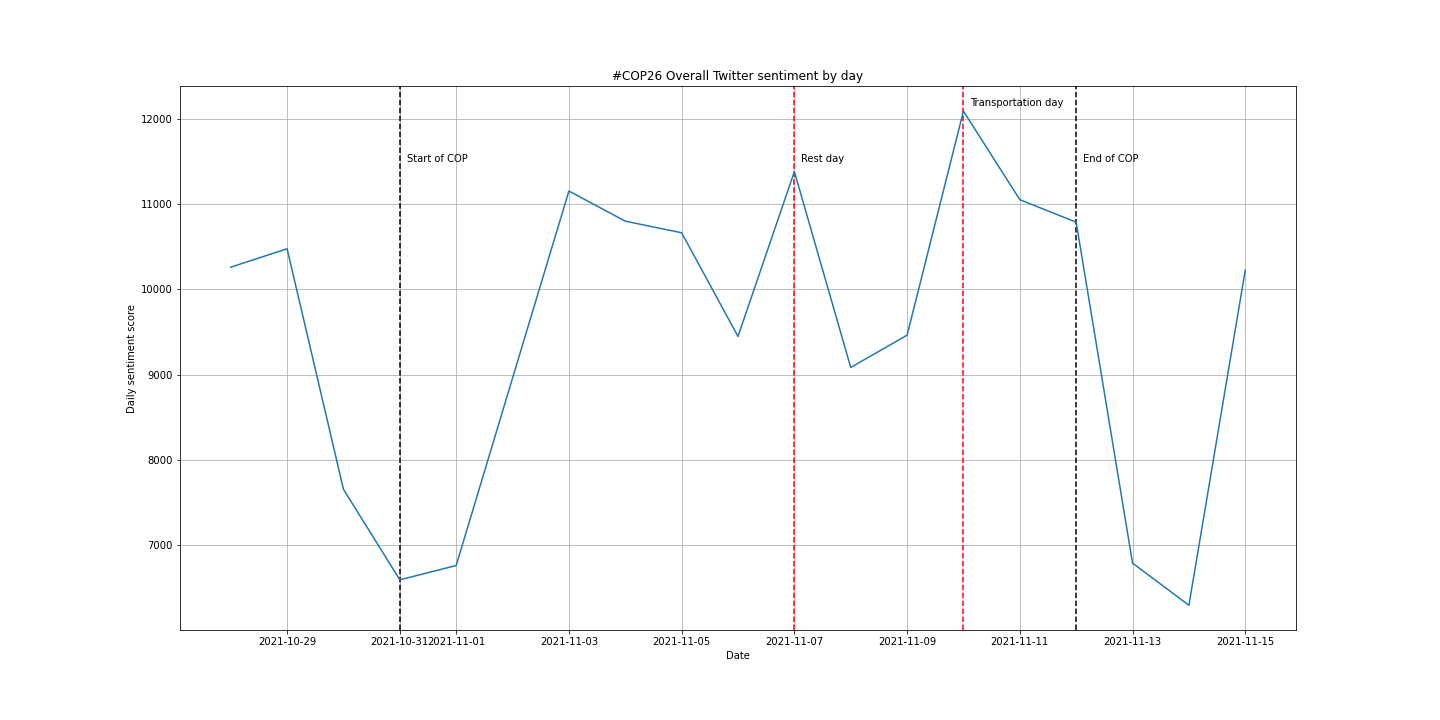

In [339]:
Image('Overallsentiment.png')

#### Takeaways

Interesting! Sentiment appears high in the days leading up to the conference, ping-pongs around a bit during, craters into a low after the conference closes on Nov 12, but mysteriously rebounds three days later on Nov 15.

There are three prominent spikes in sentiment during the conference:  
  
11/3: On the first day of actual negotiation, following the first two days of leaders-only meetings.  
11/7: On the rest day.    
11/10: Transportation-focused day. Can't explain that intuitively.  

### Topic Modeling

Now we want to dig in deeper and see if we can find groups of tweets that cluster together by distinct theme. 

We'll accomplish this using LDA (latent dirichlet analysis) modeling. LDA is an unsupervised classification algorithm.

Through trial-and-error I found taking a smaller sample of the full 285k tweets dataset gives nearly identical results, so we'll start by taking a 25k sample of tweets to work with. 

In [216]:
for_modeling_unclean = db.full_text.dropna()
for_modeling = []

for tweet in for_modeling_unclean :
    words = [w for w in tweet.split()]# if w not in cop_sw]
    words = " ".join(words)    
    for_modeling.append(words)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [217]:
random.seed(1234)
for_modeling = sample(for_modeling, 25000)  

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [218]:
# Updates spaCy's default stop words list with my additional words. 
stop_list = ['`',"Mr.","Mrs.","Ms."]
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [219]:
program_start = time.time()

doc_list = []
allowed_postags=['NOUN','ADJ','VERB','ADV']

# Iterates through each article in the corpus.
for doc in for_modeling :
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append([token.lemma_ for token in pr if token.pos_ in allowed_postags])
    
program_end = time.time()
print('Total time taken to run is {} minutes.'.format(round(program_end - program_start)/60, 2))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken to run is 7.3 minutes.


In [220]:
id2word = Dictionary(doc_list)  
id2word.filter_extremes(no_below=10, no_above=0.4)  #getting rid of fewer than 10 instances. 
                                # And no more than words that appear in a certain fraction
                                # of the total corpus size (in this case .4)
id2word.compactify()  # assign new word ids to all words. 
corpus = [id2word.doc2bow(word) for word in doc_list]


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [221]:
num_topics = 10

program_start = time.time()

lda_model = LdaMulticore(corpus=corpus, 
                             id2word=id2word, 
                             num_topics=num_topics, 
                             random_state=1,
                             chunksize=30,
                             passes=40,
                             alpha=0.31,  # sets our priors
                             eta=0.91,
                             eval_every=1,
                             per_word_topics=True,
                             workers=1)

program_end = time.time()
print('Total time taken to run is {} minutes.'.format(round(program_end - program_start)/60, 2))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken to run is 9.583333333333334 minutes.


In [331]:
pprint(lda_model.print_topics(num_words=20))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


I've taken a stab at interpreting each category, and included a selected list of words in brackets for each that convey the group's essence. 

**1) Aspiration:**  
[commitment / need / leader / pledge / promise / tackle / target ]  
This group is clustered around the aspirational pledges and commitments governments and organizations need to take to address climate change. 


**2) Random:**   
[have / do / make / get / say / think / know ]  
Lots of verbs in this grouping: make, do, get, think, etc. It seems a bit of a random grouping that's picking up on things people are doing, perhaps other things that don't fit into the other groupings. Tough to tell, and there's no real value in this group, but again like the other fairly random grouping above it continues to show up in the model even with the total number of groupings are reduced and other valuable groupings disapper. 


**3) Education:**  
[ event / join / solution / live / tomorrow / learn / discuss / discussion ]  
This grouping is a bit harder to intuit, but I believe it's picking up on educational events held throughout COP. In addition to the education-focused words shown in the summary, it picks up on climate change topics as well (like "energy", "build", "sustainable", "green", and "nature"), which to me suggests that these educational words tend to co-occur with the topics. This would make sense if this grouping tends to include tweets that are broadcasting information about the various gatherings, seminars, and discussions during the conference about these topics. 


**4) Event-focused random:**   
[ so / see / week / look / year / many / next / hope ]
I interpret this cluster as fairly random noise, an artifact of asking the model to return ten clusters. It’s interesting that this cluster continues to show up when I reduce the model groupings from 10 down to nine and eight, while other more intuitively useful clusters stop coming through. 


**5) Fossil fuels:**  
[fuel / fossil / end / coal / big / gas / government / phase / oil ]  
This group is squarely clustered around moving away from fossil fuels. I interpret the inclusion of words like “end”, “phase” and “out” (as in “phase out”), “stop”, and “commit” to show that this grouping is not tweets related to defending fossil fuels but rather focused around the need to phase them out in favor of renewable alternatives. 


**6) Collaboration:**   
[listen / together / share / community / young / Indigenous / thank ]  
I'm quite excited the model picked up on a group like this, which I'm calling Collaboration: it's distinctly focused on things like sharing, listening, working together, and young & indigenous voices, as compared to the other two action-focused groupings (Fossil fuels & Aspiration). There are also hints that this grouping picks up on themes of gratefulness & hope, judging from words like "great", "thank", "welcome", "full", and "amazing". Very cool.
    

**7) Negotiation:**   
[demand / today / crisis / negotiation / leader / summit / fight ]  
This grouping feels more tactical and urgent, focused on the specific issues the world leaders were gathered in Glasgow to discuss and negotiate.


**8) Pomp & Circumstance:**   
[good / come / important / conference / attend / speech / party / most / city / power ]  
This grouping looks like more of the self-important tweets relating to the spectacle of the conference itself moreso than any substantive climate-related discussion. 


**9) Science:**  
[warming / °, c (deg C) / time / rise / science / prevent / plan / emission / level / fact / plan ]  
This grouping looks like more technically- or science-oriented tweets. Also very cool that the model can separate these from the more activist and policy-oriented tweets. 


**10) CTAs / tracking**  
[news / tweet / petition / sign / share / read / post / link / 👇🔊 (i.e. emojis for links) ]    
This group appears to be a mix of CTA-type tweets and one or more automated flight-tracking bots. Words like those highlighted in the summary seem associated with calls-to-action, while “✈”, "ft", and "easyjet" are associated with a flight-tracking bot that likely picked up private jets going to and from the conference. 

 

In [209]:
pyLDAvis.enable_notebook()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [210]:
#pyLDAvis.gensim.prepare(lda_model, corpus, words)
pyLDAvis.gensim_models.prepare(lda_model, corpus,id2word)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.134559  0.027204       1        1  15.930678
3     -0.153093  0.149769       2        1  12.809586
9      0.012161 -0.005007       3        1  10.883602
8      0.014100 -0.068470       4        1  10.241783
2      0.018181 -0.114982       5        1  10.173012
5      0.015684 -0.079070       6        1   9.124622
1     -0.004074 -0.043956       7        1   8.665093
0      0.015275 -0.006586       8        1   8.383451
6      0.018298 -0.016279       9        1   7.110719
7      0.198029  0.157378      10        1   6.677455, topic_info=             Term        Freq       Total Category  logprob  loglift
3         climate  196.000000  196.000000  Default  30.0000  30.0000
65        unknown   63.000000   63.000000  Default  29.0000  29.0000
26   cop26glasgow   53.000000   53.000000  Default  28.0000  28.0000
47           need   68.000000   68.000000  Default  27.0000  27.0000
57           fuel   74.000000   74.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
204          hope    0.724409   17.888742  Topic10  -6.3292  -0.5001
235         share    0.819675   35.912120  Topic10  -6.2057  -1.0735
94           year    0.843388   44.740419  Topic10  -6.1771  -1.2648
149      industry    0.755940   26.696956  Topic10  -6.2866  -0.8579
106          here    0.803504   70.790766  Topic10  -6.2256  -1.7721

[381 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.026824    %
0         2  0.026824    %
0         3  0.026824    %
0         4  0.026824    %
0         5  0.831537    %
...     ...       ...  ...
69        6  0.036361    🔊
69        7  0.036361    🔊
69        8  0.036361    🔊
69        9  0.036361    🔊
69       10  0.763575    🔊

[2490 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 10, 9, 3, 6, 2, 1, 7, 8])

In [234]:
# create temp lists to pass into dataframe
tweetlist = []
categorylist = []
probabilitylist = []
topic_assignments = []


# Calculate topic probabilities for each tweet & assign tweets to categories
for tweet in for_modeling :
    doc = [w for w in tweet.split()]
    pr = nlp(" ".join(doc))
    doc = [token.lemma_ for token in pr if token.pos_ in allowed_postags]
    doc_new = id2word.doc2bow(doc)

    topic_probs = lda_model[doc_new][0]
    topic = max(topic_probs,key=lambda x: x[1])
    topic_assignments.append(topic[0])    
    prob = max(topic_probs)
    cat = topic[0]
    prob = topic[1]
    tweetlist.append(tweet)
    categorylist.append(cat)
    probabilitylist.append(prob)

tweets_df = pd.DataFrame()
tweets_df["Tweet"] = tweetlist
tweets_df["Category"] = categorylist
tweets_df["Probability"] = probabilitylist

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [246]:
newdf = tweets_df.merge(db, left_on='Tweet', right_on='full_text', how='inner')
newdf = newdf.drop_duplicates(subset=['tweet_id'], keep='first')
newdf["date_created"] = pd.to_datetime(newdf["date_created"], format="%Y-%m-%d") 
newdf['days'] = newdf['date_created'].dt.date

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [247]:
# rename columns from numbers to actual names for final display

newdf['Category'] = newdf['Category'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                                            ['Collaboration','Science','Event-focused random',
                                                             'Fossil fuels', 'Aspiration','Pomp & Circumstance',
                                                             'Verbs random','Education','Negotiation','CTAs & tracking'])
                                                             


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [249]:
newdf_groupby_category = newdf.groupby('Category')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [250]:
newdf_groupby_category.size()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Category
Aspiration              1375
CTAs & tracking          245
Collaboration            805
Education               1229
Event-focused random    1395
Fossil fuels             733
Negotiation              799
Pomp & Circumstance      849
Science                  479
Verbs random            1023
dtype: int64

In [251]:
newdf_collab = newdf_groupby_category.get_group('Collaboration')
newdf_science = newdf_groupby_category.get_group('Science')
newdf_fossil = newdf_groupby_category.get_group('Fossil fuels')
newdf_aspiration = newdf_groupby_category.get_group('Aspiration')
newdf_education = newdf_groupby_category.get_group('Education')
newdf_negotiation = newdf_groupby_category.get_group('Negotiation')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [252]:
from datetime import date, timedelta
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2021, 10, 28)
end_date = date(2021, 11, 16)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [173]:
# John - I tried condensing the code into a function but couldn't squash this bug. 
# The function is returning the scores list 3x over for each topic_df...??????

# scores = []

# def sentiment_bytopic(topicdf):
#     for single_date in daterange(start_date, end_date):
#         current = 0  # resets current var to zero between each speaker or night loop
#         for tweet in topicdf[topicdf["days"] == single_date].Tweet.unique():
#             line_b = tweet.split(' ')
#             for idx, word in enumerate(line_b):
#                 if word in sentiment_scores:
#                     current += sentiment_scores[word.lower()]
#         scores.append(current)
#     return(scores)


# actionlist = sentiment_bytopic(newdf_action)
# randomlist = sentiment_bytopic(newdf_random)
# policylist = sentiment_bytopic(newdf_policy)
            

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [253]:
collablist = []
sciencelist = []
fossillist = []
aspirationlist = []
educationlist = []
negotiationlist = []

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [254]:

for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_collab[newdf_collab["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    collablist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [255]:

for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_science[newdf_science["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    sciencelist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [256]:

for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_fossil[newdf_fossil["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    fossillist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [257]:
for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_aspiration[newdf_aspiration["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    aspirationlist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [258]:
for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_education[newdf_education["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    educationlist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [259]:
for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_negotiation[newdf_negotiation["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    negotiationlist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


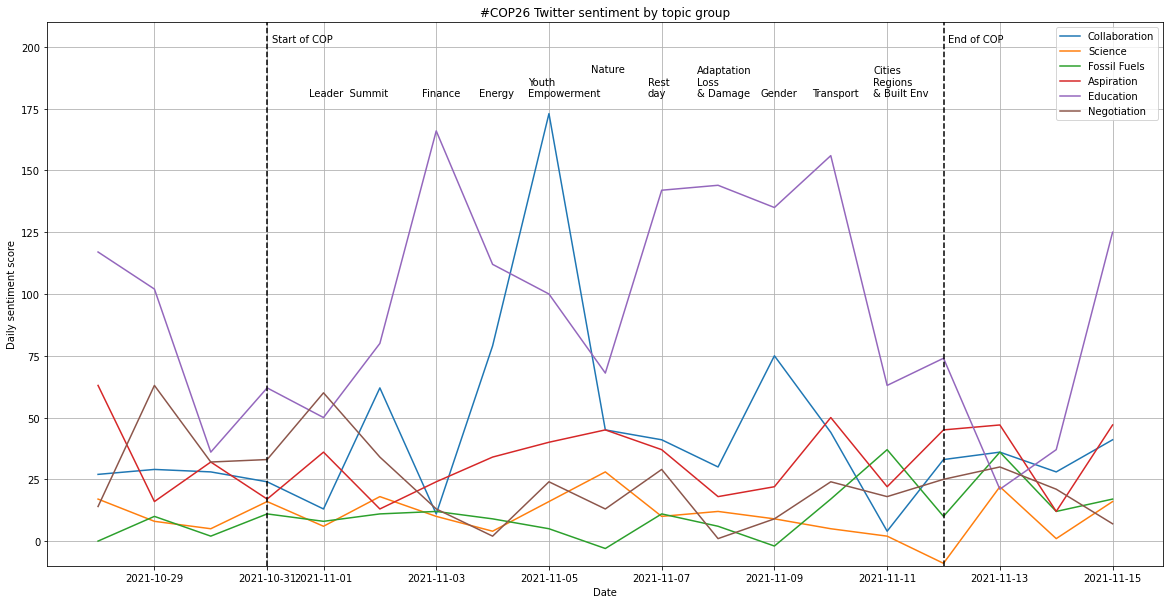

In [336]:
# Set parameters for sentiment-by-group plot

x1 = [datetime.datetime(2021,10,28),datetime.datetime(2021,10,29),datetime.datetime(2021,10,30),
     datetime.datetime(2021,10,31),datetime.datetime(2021,11,1),datetime.datetime(2021,11,2),
     datetime.datetime(2021,11,3),datetime.datetime(2021,11,4),datetime.datetime(2021,11,5),
     datetime.datetime(2021,11,6),datetime.datetime(2021,11,7),datetime.datetime(2021,11,8),
     datetime.datetime(2021,11,9),datetime.datetime(2021,11,10),datetime.datetime(2021,11,11),
     datetime.datetime(2021,11,12),datetime.datetime(2021,11,13),datetime.datetime(2021,11,14),
     datetime.datetime(2021,11,15)]

y1=collablist
y2=sciencelist
y3=fossillist
y4=aspirationlist
y5=educationlist
y6=negotiationlist

plt.figure(figsize=(20,10))
plt.grid()
plt.plot(x1, y1, label="Collaboration")

x2 = x1
plt.plot(x2, y2, label="Science")

x3 = x1
plt.plot(x3, y3, label="Fossil Fuels")

x4 = x1
plt.plot(x4, y4, label="Aspiration")

x5 = x1
plt.plot(x5, y5, label="Education")

x6 = x1
plt.plot(x6, y6, label="Negotiation")

confcoords = [datetime.datetime(2021,10,31), datetime.datetime(2021,11,12)]
for xc in confcoords:
    plt.axvline(x=xc, color='black', linestyle='dashed')

plt.annotate("Start of COP", (datetime.datetime(2021,10,31, hour=2), 202))
plt.annotate("End of COP", (datetime.datetime(2021,11,12, hour=2), 202))
plt.annotate("Leader  Summit", (datetime.datetime(2021,10,31, hour=18), 180))
plt.annotate("Finance", (datetime.datetime(2021,11,2, hour=18), 180))
plt.annotate("Energy", (datetime.datetime(2021,11,3, hour=18), 180))
plt.annotate("Youth\nEmpowerment", (datetime.datetime(2021,11,4, hour=15), 180))
plt.annotate("Nature", (datetime.datetime(2021,11,5, hour=18), 190))
plt.annotate("Rest\nday", (datetime.datetime(2021,11,6, hour=18), 180))
plt.annotate("Adaptation\nLoss\n& Damage", (datetime.datetime(2021,11,7, hour=15), 180))
plt.annotate("Gender", (datetime.datetime(2021,11,8, hour=18), 180))
plt.annotate("Transport", (datetime.datetime(2021,11,9, hour=16), 180))
plt.annotate("Cities\nRegions\n& Built Env", (datetime.datetime(2021,11,10, hour=18), 180))

plt.xlabel("Date")
plt.ylabel("Daily sentiment score")
plt.title('#COP26 Twitter sentiment by topic group')
plt.legend(loc = "upper right")
plt.ylim(-10, 210)
#plt.show()
plt.savefig('Groupsentiment.png')


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


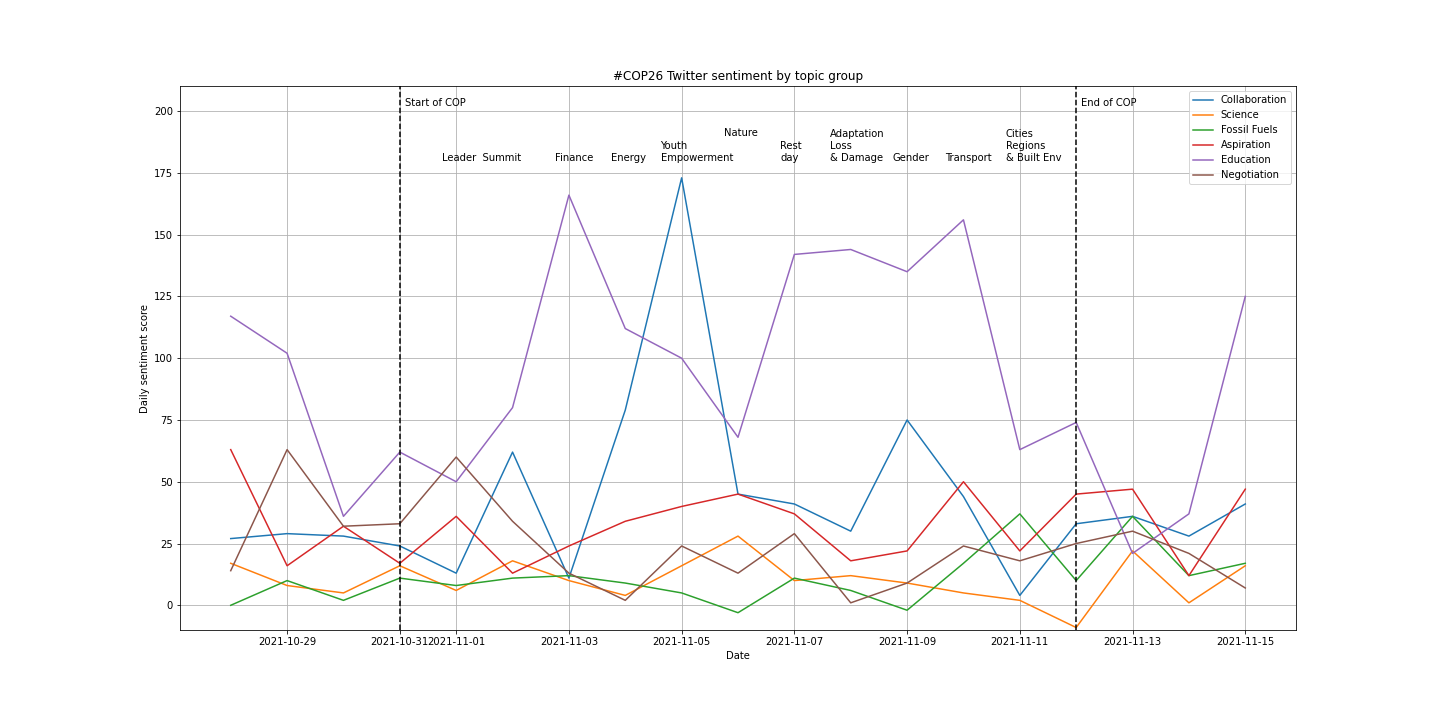

In [337]:
from IPython.display import Image
Image('Groupsentiment.png')

- Education has highest mean sentiment across conference
- Lots of noise, but some clear signals: like spikes in "Collaboration" sentiment on Youth Empowerment and Women's Role days.
- Negotiation sentiment trends downward throughout
- Every category except Fossil Fuels trended downward 


Sunday 31 October - Procedural opening of negotiations

Monday and Tuesday 1-2 November - World leaders summit: A two-day event welcoming heads of state and inviting them to put forward their ambitions and proposals towards securing global net zero carbon emissions, keeping the 1.5C temperature increase target within reach, protecting ecosystems and mobilising finance

Wednesday 3 November - Finance: Mobilising public and private finance flows at scale for mitigation and adaptation

Thursday 4 November - Energy: Accelerating the global transition to clean energy

Friday 5 November - Youth and public empowerment: Elevating the voice of young people and demonstrating the critical role of public empowerment and education in climate action

Saturday 6 November - Nature: Ensuring the importance of nature and sustainable land use are part of global action on climate change and a clean, green recovery

Sunday 7 November - Rest day

Monday 8 November - Adaptation, loss and damage: Delivering the practical solutions solutions needed to adapt to climate impact and address loss and damage

Tuesday 9 November - Gender: Progressing gender equality and the full and meaningful participation of women and girls in climate action
Science and innovation: Demonstrating that research and technology can deliver climate solutions to meet, and accelerate, increased ambition

Wednesday 10 November - Transport: Driving the global transition to zero emission transport

Thursday 11 November - Cities, Regions and Built Environment: Advancing action in the places we live, from communities, through to cities and regions  
  
Friday 12 November - Closure of negotiations

In [269]:
sum(collablist) / len(collablist)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


43.31578947368421

In [281]:
sum(collablist) / len(collablist)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


94.21052631578948

In [282]:
sum(sciencelist) / len(sciencelist)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10.31578947368421

In [283]:
sum(fossillist) / len(fossillist)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


11.0